In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np

In [4]:
os.chdir('/content/drive/MyDrive/Colab_Notebooks/RecSys')

In [5]:
df = pd.read_csv('data/train.csv')

### Session time

In [8]:
df_ = df[['session_id', 'timestamp']]
df_['timestamp'] = pd.to_datetime(df_.timestamp, unit = 's')
df_time = df_.groupby('session_id').agg(['min', 'max'])
df_time.columns = ['min', 'max']
df_time['time_session'] = df_time['max'] - df_time['min']
df_time['time_session'] = df_time['time_session'].apply(lambda x: x.total_seconds())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


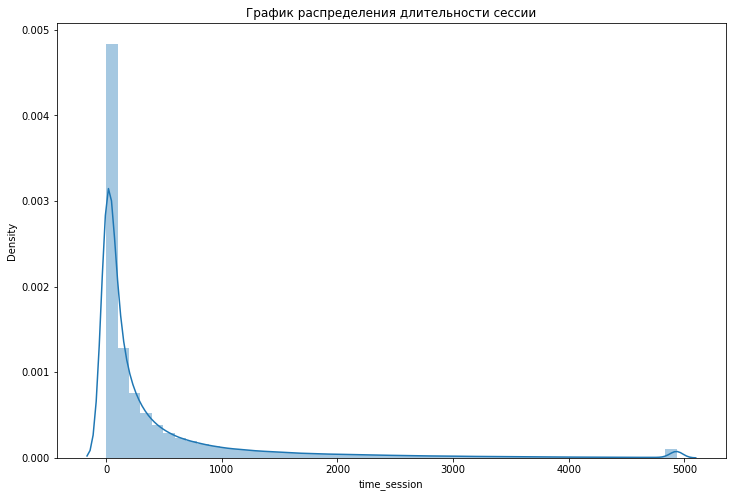

In [9]:
plt.figure(figsize=(12, 8))
plt.title('График распределения длительности сессии')
sns.distplot(df_time['time_session'].clip(upper = df_time['time_session'].quantile(0.99)))

### Wages

In [11]:
salary = pd.read_csv('data/salaries_with_domains.csv', index_col=0)
salary.set_index('Data Source', inplace = True)
salary = salary.to_dict()['2019.0']
df['salaries'] = df.platform
df['salaries'] = df.salaries.map(salary)
list_nf = df[df.salaries.isna()].platform.value_counts().index.to_list()
check_ = df.salaries.fillna(df.salaries.mean())
df['salary'] = check_

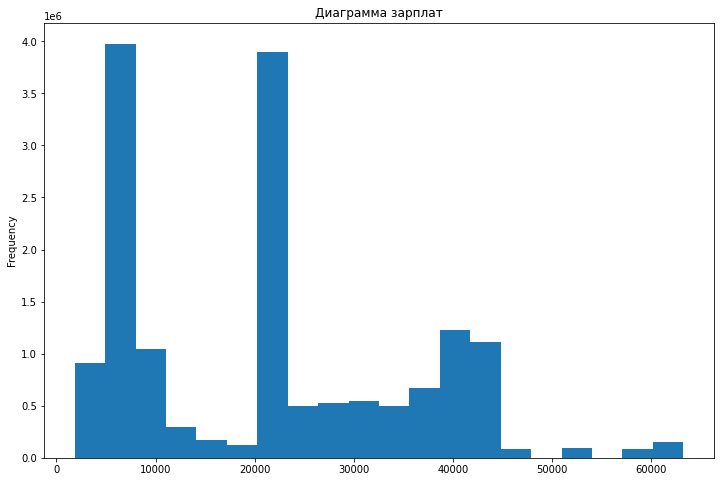

In [12]:
plt.figure(figsize=(12,8))
plt.title('Диаграмма зарплат')
df['salary'].plot.hist(bins = 20)

In [15]:
filter_change = []
steps_session = []
last_acion_session = []
all_prices = []

def get_price_per_salary(df):
    # Посмотрим на метрику отношения цены объекта к зарплате юзера
    # all_prices = []  - цены

    clicks = df[(df['action_type'] == 'clickout item')]
    
    if len(clicks) > 0:    
        price_per_salary = []
        last_click = clicks.tail(1)
        prices = list(map(int, clicks['prices'].values[0].split('|')))
        salary_ = clicks['salary'].values[0]
        result = np.array(prices) / np.array(salary_)
        all_prices.append(result)

In [16]:
def get_other_metrics(df):
    # Посмотрим следующие метрики: 
    # filter_change = [] - менял ли юзер фильтр
    # steps_session = [] - количество шагов в сессии
    # last_acion_session = [] - последний тип действия в сессии

    last_action = df.action_type.tail(1).values[0]
    step_session = df.step.tail(1).values[0]
    filters = df.current_filters.nunique()
    filter_change.append(filters)
    steps_session.append(step_session)
    last_acion_session.append(last_action)

In [17]:
only_nedeed_salary_price = df.loc[:, [
    'user_id', 'session_id', 'prices', 'salary', 'action_type', 'step', 'current_filters' 
                                     ]]

In [18]:
from tqdm.notebook import tqdm
tqdm.pandas()
only_nedeed_salary_price.groupby(['user_id', 'session_id']).progress_apply(get_price_per_salary)

  0%|          | 0/910683 [00:00<?, ?it/s]

""


In [19]:
from tqdm.notebook import tqdm
tqdm.pandas()
only_nedeed_salary_price.groupby(['user_id', 'session_id']).progress_apply(get_other_metrics)

  0%|          | 0/910683 [00:00<?, ?it/s]

""


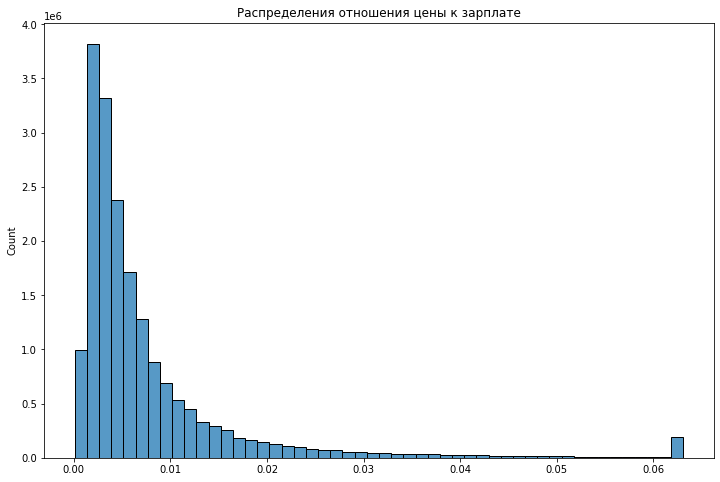

In [22]:
all_prices = [j for i in all_prices for j in i]
checking = np.clip(np.array(all_prices),a_min = 0, a_max = np.quantile(np.array(all_prices), 0.99))
plt.figure(figsize=(12,8))
plt.title('Распределения отношения цены к зарплате')
sns.histplot(checking, bins = 50)

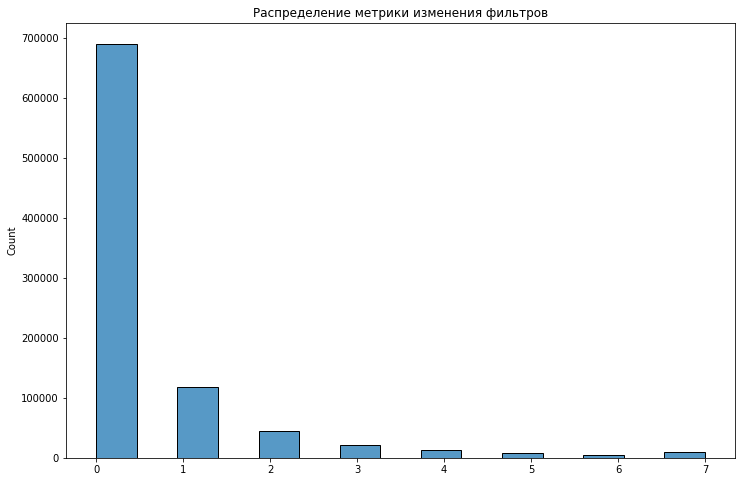

In [28]:
checking = np.clip(np.array(filter_change),a_min = 0, a_max = np.quantile(np.array(filter_change), 0.99))
plt.figure(figsize=(12,8))
plt.title('Распределение метрики изменения фильтров')
sns.histplot(checking, bins = 15)

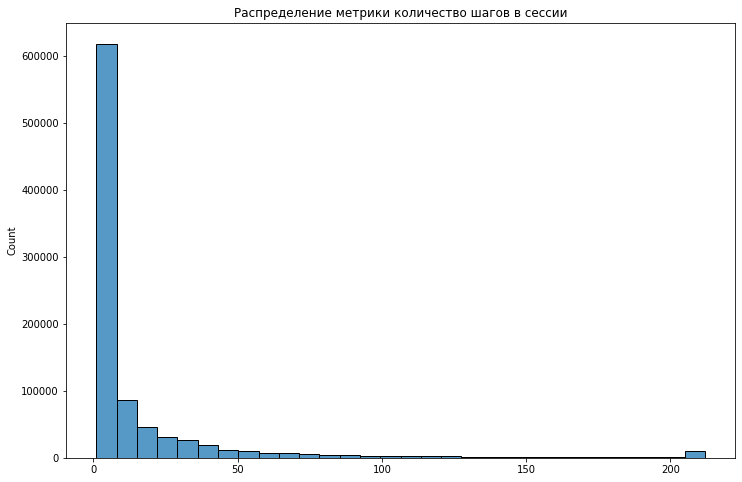

In [35]:
checking = np.clip(np.array(steps_session),a_min = 0, a_max = np.quantile(np.array(steps_session), 0.99))
plt.figure(figsize=(12,8))
plt.title('Распределение метрики количество шагов в сессии')
sns.histplot(checking, bins = 30)

In [38]:
from collections import Counter
c = Counter(last_acion_session)

In [39]:
c

Counter({'interaction item deals': 36646,
         'clickout item': 655218,
         'interaction item image': 108009,
         'search for poi': 8508,
         'search for destination': 25218,
         'filter selection': 22775,
         'interaction item rating': 16879,
         'interaction item info': 22891,
         'change of sort order': 3824,
         'search for item': 10715})

In [43]:
list(c.values())

[36646, 655218, 108009, 8508, 25218, 22775, 16879, 22891, 3824, 10715]

In [46]:
list(c.values()).index(max(list(c.values())))

1

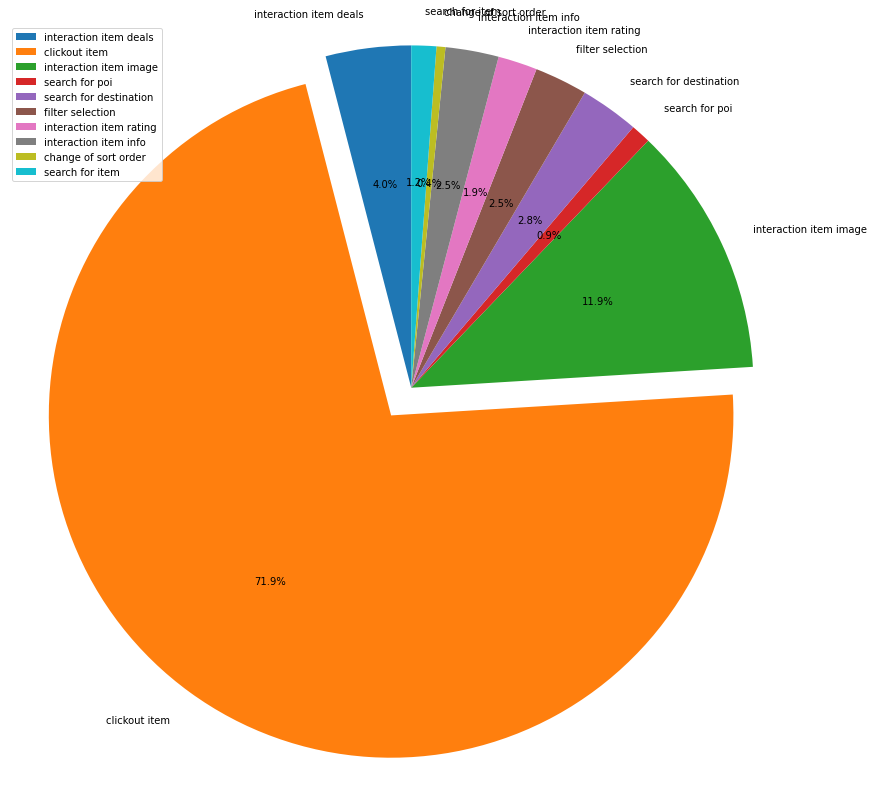

In [57]:
labels = list(c.keys())
sizes = list(c.values())
explode = (0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0)

fig1 = plt.figure(figsize=(14, 14))
ax1 = plt.subplot()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')
plt.legend()

plt.show()